# **How to Train  and test YOLOv5 on our dataset ( iranian vehicle dataset )**

This tutorial is based on the YOLOv5 repository by our team. 

**Use GPU:**

Click the **“Runtime”** dropdown menu. Select **“Change runtime type”**. Now select  **GPU** .
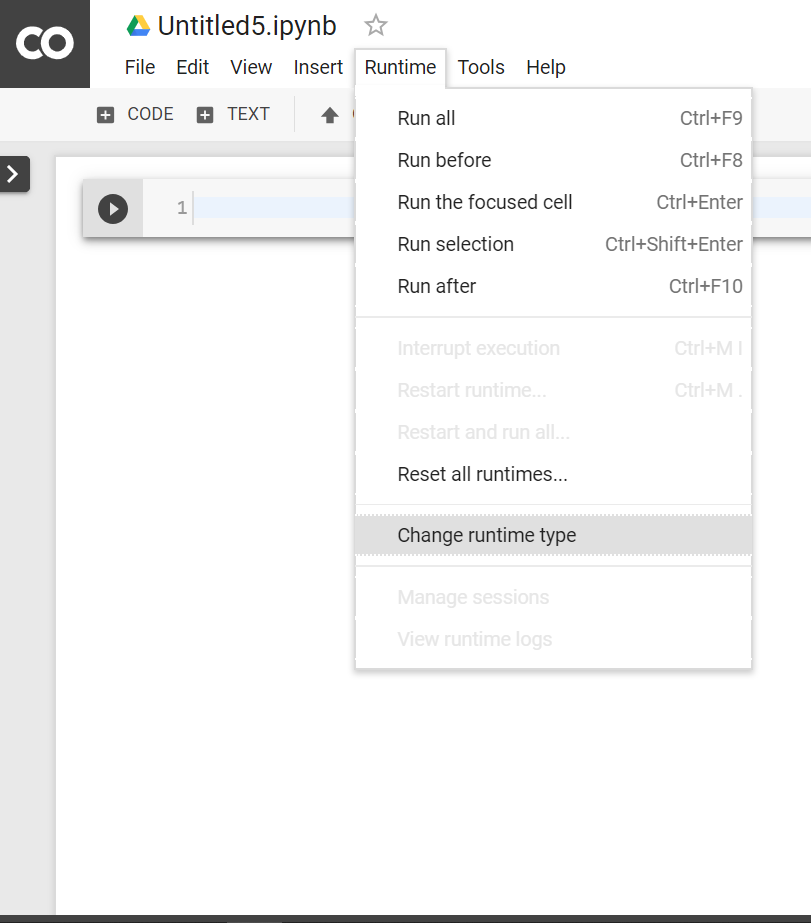

In [ ]:
# cheack GPU
!nvidia-smi

Thu Aug 18 06:50:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    39W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#setup

In [ ]:
# Clone YOLOv5
!git clone https://github.com/ultralytics/yolov5  # clone YOLOv5
%cd yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.12.1+cu113 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# download dataset

**install Roboflow and Download Dataset from Roboflow**
---
We'll download our dataset from Roboflow. Use the "YOLOv5 PyTorch" export format. 

In [ ]:
#Download Dataset from Roboflow
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="2nHvCKNGqDIegIXcDa7v")
project = rf.workspace("sipo").project("iranian-vehicle-cjfc5")
dataset = project.version(2).download("yolov5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to iranian-vehicle-2 in yolov5pytorch:: 100%|██████████| 6012/6012 [00:00<00:00, 6118.40it/s]


In [ ]:
# this is the YAML file  Roboflow wrote for our dataset
%cat {dataset.location}/data.yaml
%cd /content/yolov5

names:
- Truck
- bus
- car
nc: 3
train: iranian-vehicle-2/train/images
val: iranian-vehicle-2/valid/images
/content/yolov5


# Train

# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Train  YOLOv5 Detector for our dataset

### Next, we'll fire off training!

Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs.
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights.
- **name:** result names
- **cache:** cache images for faster trainin

In [ ]:
# train yolov5x on custom data for 200 epochs
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 128 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_results --cache

/content/yolov5
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=/content/yolov5/iranian-vehicle-2/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=128, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-10-g5c854fa Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, ob

# # Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [ ]:
!cp -r /content/drive/MyDrive/iranian_dataset_200epoch_aftereditdataset/content/yolov5/runs /content/yolov5

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
# output some older school graphs
from IPython.display import Image, clear_output  # to display images
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

In [ ]:
# print out an augmented training example (Mosaic augmentation)
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

# save and use best trained weight in  weights folder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%ls runs/train/yolov5s_results/weights

In [ ]:
# use the best weights!
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.3 --source /content/yolov5/iranian-vehicle-2/test/images

In [ ]:
#display inference on test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
!rsync -Rr /content/yolov5/runs /content/gdrive/MyDrive/iranian_dataset_200epoch_aftereditdataset

## Congrats!
